In [1]:
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Subset

from torchvision.datasets import CIFAR10
from torchvision import transforms

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Чтение и подготовка данных

- превратить картинки в тензоры, для этого есть ToTensor()
- нормализовать данные от 0 до 1 (значения от 0 до 255 имеют большой скейл и нейронки хуже будут с ними работать)

In [2]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

Готовый датасет из PyTorch и загрузчик данных для создания батчей

In [3]:
train_dataset = CIFAR10(root='./cifar10/', train=True, download=True, transform=transform)

Files already downloaded and verified


In [4]:
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)

Семпл:

In [5]:
batch = next(iter(train_loader))
batch[0].shape, batch[1].shape

(torch.Size([8, 3, 32, 32]), torch.Size([8]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5324942..2.0663116].


(32, 32, 3) tensor(6)


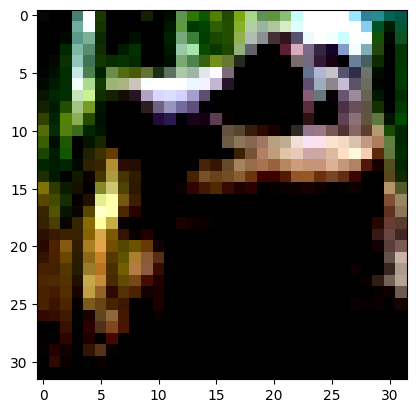

In [6]:
sample_img = batch[0].numpy()[0].transpose(1, 2, 0)
print(sample_img.shape, batch[1][0])

plt.imshow(sample_img)

# Простая CNN

3 свертки и пулинг

In [7]:
class BasicCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 64 * 4 * 4)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [8]:
cnn = BasicCNN()

out = cnn(batch[0])
print(out.shape)

torch.Size([8, 10])


# Код для тренировки

Тренировка и тестирование будет реализованно в классе Trainer

Обозначим конфиг, где будут параметры для тренировки

In [9]:
config_BasicCNN = {
    'model': BasicCNN,
    'num_epochs': 10,
    'lr': 0.01,
    'batch_size': 128,
    'test_size': 0.2
}

In [10]:
class Trainer():
    def __init__(self, config, transform=None):
        self.config = config
        self.transform = transform

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.model = self.config['model']().to(self.device)
        self.optimizer = Adam(self.model.parameters(), lr=self.config['lr'])
        self.scheduler = StepLR(self.optimizer, step_size=5, gamma=0.1)
        self.loss_function = nn.CrossEntropyLoss()

        self.setup_dataloders()

        # Сравнение моделей
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def setup_dataloders(self):
        train_dataset_full = CIFAR10(root='cifar10/', train=True, download=True, transform=self.transform)
        test_dataset = CIFAR10(root='cifar10/', train=False, download=True, transform=self.transform)

        train_indices, val_indices = train_test_split(list(range(len(train_dataset_full))), test_size=self.config['test_size'], random_state=42, shuffle=True)

        train_dataset = Subset(train_dataset_full, train_indices)
        val_dataset = Subset(train_dataset_full, val_indices)

        self.train_loader = DataLoader(dataset=train_dataset, batch_size=self.config['batch_size'], shuffle=True)
        self.val_loader = DataLoader(dataset=val_dataset, batch_size=self.config['batch_size'], shuffle=False)
        self.test_loader = DataLoader(dataset=test_dataset, batch_size=self.config['batch_size'], shuffle=False)

    def run(self):
        for epoch in range(self.config['num_epochs']):
            train_loss, train_acc = self.train_step()
            val_loss, val_acc = self.validate()

            # Сохранение метрик
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            print(f"Epoch {epoch + 1} / {self.config['num_epochs']}, train loss {train_loss:.4f}, train accuracy {train_acc:.4f} \
                    val loss {val_loss:.4f}, val accuracy {val_acc:.4f}")

        test_loss, test_acc = self.test()
        print(f"Test loss {test_loss:.4f}, test accuracy {test_acc:.4f}")

    def train_step(self):
        self.model.train()

        total_loss = 0.0
        correct = 0
        total_samples = 0

        for images, labels in tqdm(self.train_loader):
            images, labels = images.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()

            outputs = self.model(images)
            loss = self.loss_function(outputs, labels)

            loss.backward()

            self.optimizer.step()

            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

        self.scheduler.step()

        total_loss = total_loss / len(self.train_loader)
        train_acc = correct / total_samples * 100

        return total_loss, train_acc

    #only loss, no train
    def validate(self):
        self.model.eval()

        total_loss = 0.0
        correct = 0
        total_samples = 0

        with torch.no_grad():
            for images, labels in tqdm(self.val_loader):
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                loss = self.loss_function(outputs, labels)

                total_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total_samples += labels.size(0)

        total_loss = total_loss / len(self.val_loader)
        val_acc = correct / total_samples * 100

        return total_loss, val_acc

    def test(self):
        self.model.eval()

        total_loss = 0.0
        correct = 0
        total_samples = 0

        with torch.no_grad():
            for images, labels in tqdm(self.test_loader):
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                loss = self.loss_function(outputs, labels)

                total_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total_samples += labels.size(0)

        total_loss = total_loss / len(self.test_loader)
        test_acc = correct / total_samples * 100

        return total_loss, test_acc

In [11]:
trainer_CNN = Trainer(config_BasicCNN, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
trainer_CNN.run()

100%|██████████| 79/79 [00:11<00:00,  6.89it/s]


Epoch 1 / 10, train loss 1.7931, train accuracy 33.7050                     val loss 1.5893, val accuracy 41.1100


100%|██████████| 79/79 [00:07<00:00, 10.99it/s]


Epoch 2 / 10, train loss 1.5066, train accuracy 45.2625                     val loss 1.4390, val accuracy 47.8200


100%|██████████| 79/79 [00:05<00:00, 13.37it/s]


Epoch 3 / 10, train loss 1.4108, train accuracy 49.3800                     val loss 1.4229, val accuracy 48.3700


100%|██████████| 79/79 [00:08<00:00,  9.67it/s]


Epoch 4 / 10, train loss 1.3586, train accuracy 51.0450                     val loss 1.3824, val accuracy 49.6300


100%|██████████| 79/79 [00:06<00:00, 11.46it/s]


Epoch 5 / 10, train loss 1.3224, train accuracy 52.3925                     val loss 1.4005, val accuracy 50.7200


100%|██████████| 79/79 [00:06<00:00, 11.51it/s]


Epoch 6 / 10, train loss 1.1560, train accuracy 58.2450                     val loss 1.2220, val accuracy 56.3200


100%|██████████| 79/79 [00:05<00:00, 13.44it/s]


Epoch 7 / 10, train loss 1.1117, train accuracy 59.8900                     val loss 1.2049, val accuracy 57.2000


100%|██████████| 79/79 [00:05<00:00, 13.19it/s]


Epoch 8 / 10, train loss 1.0894, train accuracy 60.6025                     val loss 1.1949, val accuracy 57.2800


100%|██████████| 79/79 [00:05<00:00, 13.35it/s]


Epoch 9 / 10, train loss 1.0713, train accuracy 61.1800                     val loss 1.1925, val accuracy 57.7300


100%|██████████| 79/79 [00:05<00:00, 13.30it/s]


Epoch 10 / 10, train loss 1.0579, train accuracy 61.7400                     val loss 1.1854, val accuracy 57.8100


100%|██████████| 79/79 [00:06<00:00, 12.44it/s]

Test loss 1.1843, test accuracy 58.3300


# ResNet-18

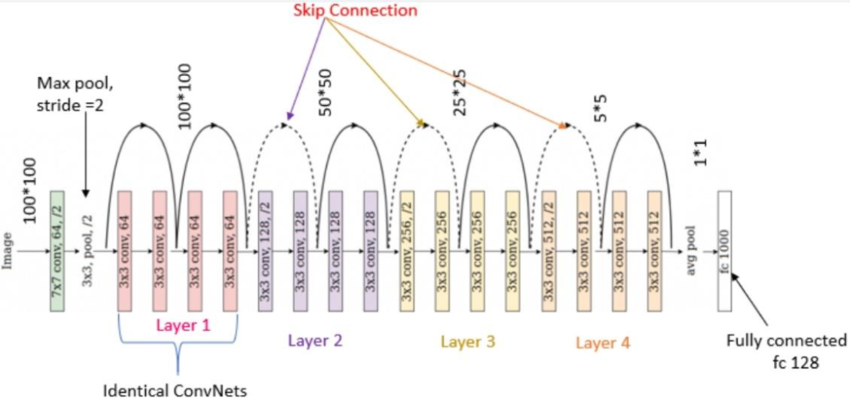

In [13]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        if self.downsample is not None:
            identity = self.downsample(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += identity
        out = F.relu(out)

        return out


class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Добавить слои
        self.layer1 = self.make_layer(64, 2)
        self.layer2 = self.make_layer(128, 2, 2)
        self.layer3 = self.make_layer(256, 2, 2)
        self.layer4 = self.make_layer(512, 2, 2)

        # Добавить пулинг на выходе + FC слой
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, 10)

    def make_layer(self, out_channels, blocks, stride=1):
        downsample = None

        if stride != 1 or self.in_channels != out_channels:
            # Добавить downsample
            downsample = nn.Sequential(
            nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=2, padding=0),
            nn.BatchNorm2d(out_channels))

        layers = []

        # 1  блок
        layers.append(ResNetBlock(self.in_channels, out_channels, stride, downsample))

        self.in_channels = out_channels
        # блок после skip_connection
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))

        # Собрать блоки в один Sequential - линейный стек слоев
        return nn.Sequential(*layers)

    # Написать forward
    def forward(self, x):
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

$H_{out}=\frac{H_{in}+2P-D(K-1)-1}{S}+1$ \\
$W_{out}=\frac{W_{in}+2P-D(K-1)-1}{S}+1$

In [14]:
# Запустить Trainer с ResNet18
config_ResNet18 = {
    'model': ResNet18,
    'num_epochs': 10,
    'lr': 0.01,
    'batch_size': 128,
    'test_size': 0.2
}

In [15]:
trainer_ResNet18 = Trainer(config_ResNet18, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
trainer_ResNet18.run()

100%|██████████| 79/79 [00:31<00:00,  2.53it/s]


Epoch 1 / 10, train loss 1.8468, train accuracy 34.9675                     val loss 1.6198, val accuracy 44.9400


100%|██████████| 79/79 [00:25<00:00,  3.07it/s]


Epoch 2 / 10, train loss 1.3580, train accuracy 51.3625                     val loss 1.3808, val accuracy 49.6900


100%|██████████| 79/79 [00:26<00:00,  2.95it/s]


Epoch 3 / 10, train loss 1.1072, train accuracy 60.6950                     val loss 1.0450, val accuracy 62.9000


100%|██████████| 79/79 [00:26<00:00,  2.94it/s]


Epoch 4 / 10, train loss 0.9327, train accuracy 67.1975                     val loss 0.9214, val accuracy 68.2300


100%|██████████| 79/79 [00:27<00:00,  2.90it/s]


Epoch 5 / 10, train loss 0.8073, train accuracy 71.8175                     val loss 0.8694, val accuracy 70.0800


100%|██████████| 79/79 [00:28<00:00,  2.77it/s]


Epoch 6 / 10, train loss 0.5306, train accuracy 81.3800                     val loss 0.7265, val accuracy 75.5300


100%|██████████| 79/79 [00:27<00:00,  2.89it/s]


Epoch 7 / 10, train loss 0.4377, train accuracy 84.5825                     val loss 0.7442, val accuracy 75.6500


100%|██████████| 79/79 [00:26<00:00,  2.94it/s]


Epoch 8 / 10, train loss 0.3709, train accuracy 86.9650                     val loss 0.7706, val accuracy 75.9000


100%|██████████| 79/79 [00:28<00:00,  2.81it/s]


Epoch 9 / 10, train loss 0.2974, train accuracy 89.8250                     val loss 0.8352, val accuracy 74.8800


100%|██████████| 79/79 [00:27<00:00,  2.87it/s]


Epoch 10 / 10, train loss 0.2248, train accuracy 92.3200                     val loss 0.9199, val accuracy 75.3300


100%|██████████| 79/79 [00:26<00:00,  2.93it/s]

Test loss 0.9630, test accuracy 74.1800


# Сравнение качеств

In [17]:
import matplotlib.pyplot as plt

In [18]:
train_losses_CNN = trainer_CNN.train_losses
val_losses_CNN = trainer_CNN.val_losses
train_accuracies_CNN = trainer_CNN.train_accuracies
val_accuracies_CNN = trainer_CNN.val_accuracies

train_losses_ResNet18 = trainer_ResNet18.train_losses
val_losses_ResNet18 = trainer_ResNet18.val_losses
train_accuracies_ResNet18 = trainer_ResNet18.train_accuracies
val_accuracies_ResNet18 = trainer_ResNet18.val_accuracies

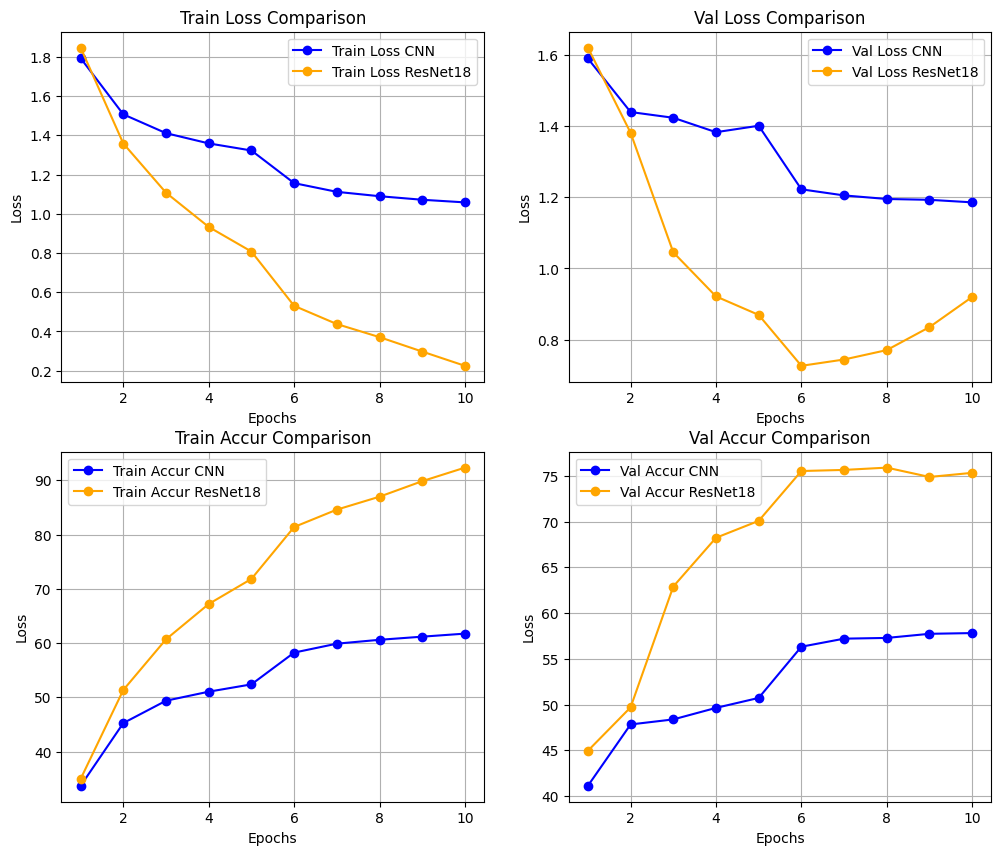

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].plot(range(1, len(train_losses_CNN) + 1), train_losses_CNN, label='Train Loss CNN', color='blue', marker='o')
axs[0, 0].plot(range(1, len(train_losses_ResNet18) + 1), train_losses_ResNet18, label='Train Loss ResNet18', color='orange', marker='o')
axs[0, 0].set_title('Train Loss Comparison')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].grid()

axs[0, 1].plot(range(1, len(val_losses_CNN) + 1), val_losses_CNN, label='Val Loss CNN', color='blue', marker='o')
axs[0, 1].plot(range(1, len(val_losses_ResNet18) + 1), val_losses_ResNet18, label='Val Loss ResNet18', color='orange', marker='o')
axs[0, 1].set_title('Val Loss Comparison')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid()

axs[1, 0].plot(range(1, len(train_accuracies_CNN) + 1), train_accuracies_CNN, label='Train Accur CNN', color='blue', marker='o')
axs[1, 0].plot(range(1, len(train_accuracies_ResNet18) + 1), train_accuracies_ResNet18, label='Train Accur ResNet18', color='orange', marker='o')
axs[1, 0].set_title('Train Accur Comparison')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()
axs[1, 0].grid()

axs[1, 1].plot(range(1, len(val_accuracies_CNN) + 1), val_accuracies_CNN, label='Val Accur CNN', color='blue', marker='o')
axs[1, 1].plot(range(1, len(val_accuracies_ResNet18) + 1), val_accuracies_ResNet18, label='Val Accur ResNet18', color='orange', marker='o')
axs[1, 1].set_title('Val Accur Comparison')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()
axs[1, 1].grid()

Итог: ResNet18 занимает больше времени на обучение и валидацию, чем CNN. ResNet18 лучше справляется с уменьшением loss-а и на тестовой и на валидационной выборке, а также почти в 1,5 раза увеличивает accuracy в сравнении с CNN.